## Modi Omkar
## 19EE30018
## Assignement 1

In [1]:
#importing libraries
import random
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel, ConstantKernel, Product, Sum,\
                                            Exponentiation, DotProduct,Matern
from pykrige.rk import RegressionKriging

selecting 10 random coordinates from 20X20 region and assigning observed value as s1+s2+random noise

In [2]:
seed = 19
np.random.seed(seed)

#selecting 10 random variables from 20X20 region.
locations_cordinates = np.random.uniform(0,20, size = (10,2))

#observed data  X(s,t)= s1 + s2 + random noise
#random noise is choosen from normal distibution with mean at zero
s1_plus_s2 = np.sum(locations_cordinates,axis = 1)
s1_plus_s2 = np.reshape(s1_plus_s2,(10,1))

X_A1 =  s1_plus_s2+np.random.normal(size=(10,100))
 
loc_dataset = pd.DataFrame({'S1':locations_cordinates[:,0],'S2':locations_cordinates[:,1],'X(s,t=1)':X_A1[:,0]})
print(loc_dataset)

          S1         S2   X(s,t=1)
0   1.950672  15.224994  17.702201
1   4.938759   2.762634   6.992443
2   6.628931   1.659991   9.197810
3  13.439542  16.131876  30.419725
4  19.654838  12.713215  32.265764
5   4.318465  10.980549  15.654181
6  10.911199   4.681521  16.087022
7   2.274517   9.993185  11.230911
8   3.042168  10.653722  11.258587
9   7.740135  13.766548  22.218538


The data for these 20 locations are gaussian process with different kernels.

In [3]:
def gaussian_process(kernel):
    gpr = GaussianProcessRegressor(kernel = kernel, random_state = seed)
    gpr.fit(locations_cordinates,X_A1)

    print(f"Kernel parameters before fit:\n{kernel})")
    print(
        f"Kernel parameters after fit: \n{gpr.kernel_} \n"
        f"Log-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f}"
    )
    return gpr

Gaussian process regressor on fitting the location coordinates and observed data returns the mean and variance of the data.
Using a normal distribution with the obtained mean and variance, a spatio-temporal value is
sampled.

In [4]:
kernel = 1*RBF()
gpr1 = gaussian_process(kernel)

Kernel parameters before fit:
1**2 * RBF(length_scale=1))
Kernel parameters after fit: 
17.8**2 * RBF(length_scale=4.88) 
Log-likelihood: -3646.629


**Radial basis Function** - The RBF kernel function for two points X₁ and X₂ computes the similarity or how close they are to each other. This kernel can be mathematically represented as follows:
     
![RBF](1.jpeg "RBF")

where,
1. ‘σ’ is the variance and our hyperparameter
2. ||X₁ - X₂|| is the Euclidean (L₂-norm) Distance between two points X₁ and X₂

In [5]:
kernel = 1* RationalQuadratic()
gpr2 = gaussian_process(kernel)

Kernel parameters before fit:
1**2 * RationalQuadratic(alpha=1, length_scale=1))
Kernel parameters after fit: 
22.5**2 * RationalQuadratic(alpha=0.0392, length_scale=12.4) 
Log-likelihood: -3085.244


The RationalQuadratic kernel can be seen as a scale mixture (an infinite sum) of RBF kernels with different characteristic length-scales. It is parameterized by a length-scale parameter l>0 and $\alpha$>0 a scale mixture parameter  Only the isotropic variant where l is a scalar is supported at the moment. The kernel is given by:

![Rational Quadratic](2.png "RQ")

In [6]:
kernel = 1* Matern()
gpr3 = gaussian_process(kernel)

Kernel parameters before fit:
1**2 * Matern(length_scale=1, nu=1.5))
Kernel parameters after fit: 
18**2 * Matern(length_scale=17, nu=1.5) 
Log-likelihood: -3066.252


The Matern kernel is a stationary kernel and a generalization of the RBF kernel. It has an additional parameter v which controls the smoothness of the resulting function. It is parameterized by a length-scale parameter l>0, which can either be a scalar (isotropic variant of the kernel) or a vector with the same number of dimensions as the inputs x (anisotropic variant of the kernel). The kernel is given by:

![Matern](3.png "3")

![type](4.png "4")

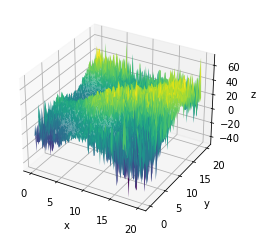

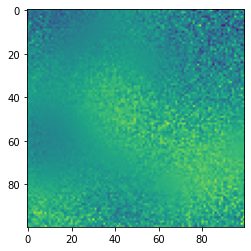

In [7]:
def f(x,y,t):
    Z = np.zeros((x.shape[0],x.shape[0]))
    for i in range(x.shape[0]):
        mean, std = gpr1.predict(np.column_stack((X[i],Y[i])), return_std = True)
        y = np.random.normal(loc = mean[:,t-1], scale = std)
        Z[i] = y;
    return Z

fig = plt.figure()

x = np.linspace(0, 20, 100)
y = np.linspace(0, 20, 100)

X, Y = np.meshgrid(x, y)

Z = f(X,Y,1)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='viridis', edgecolor='none');
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

fig = plt.figure()
plt.imshow(Z)
plt.show()


Now we select 20 random points sampled from generated Gaussian process and fit kriging on these data points

(20, 100)
(2000,)
(2000,)
(2000,)


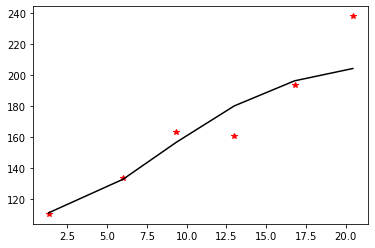

In [8]:
loc_3 = np.random.uniform(0,20, size = (20,2))

mean,std = gpr1.predict(loc_3,return_std=True)
std = std.reshape((std.shape[0],1))
y = np.random.normal(loc = mean,scale = std)
print(y.shape)
from pykrige.uk import UniversalKriging

x_d = np.ones((loc_3.shape[0],100))*(loc_3[:,0].reshape(loc_3.shape[0],1))
x_d = x_d.flatten('F')
y_d = np.ones((loc_3.shape[0],100))*(loc_3[:,1].reshape(loc_3.shape[0],1))
y_d = y_d.flatten('F')

val = y.flatten('F')
print(x_d.shape)
print(y_d.shape)
print(val.shape)
krig = UniversalKriging(x_d,y_d,val,variogram_model="gaussian")

krig.display_variogram_model()



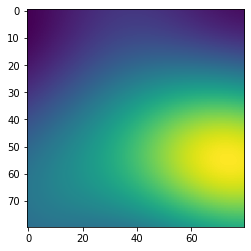

In [9]:
gridx = np.arange(0.0, 20, 0.25)
gridy = np.arange(0.0, 20, 0.25)

z, ss = krig.execute("grid", gridx, gridy)
plt.imshow(z)
plt.show()

Comparing the predicted values using Kriging and the values sampled using the Gaussian process,
the following R2 score was obtained between the values.

In [10]:
location_points = np.random.uniform(0,20, size = (15,2))
estimated,ks = krig.execute("points",location_points[:,0],location_points[:,1])

generated = gpr1.predict(location_points)
g = generated[:,0]

generated = gpr2.predict(location_points)
g2 = generated[:,0]

generated = gpr3.predict(location_points)
g3 = generated[:,0]

df_a1_3 = pd.DataFrame({"S1":location_points[:,0],"S2":location_points[:,1],"Gaussian RBF":g,"Gaussian RationalQuad":g2,"Gaussian Matern":g3,"kriging":estimated})
print(df_a1_3)
print('----------------------------------------------')
print("r2 score for estimated data and generated data for RBF : ",r2_score(g,estimated))
print("r2 score for estimated data and generated data for Rational Quad : ",r2_score(g2,estimated))
print("r2 score for estimated data and generated data for Matern : ",r2_score(g3,estimated))

           S1         S2  Gaussian RBF  Gaussian RationalQuad  \
0   18.885596  17.540927     29.077821              30.979466   
1   19.105761  10.588170     27.053123              30.207824   
2    8.385703  12.502919     26.870286              22.691065   
3    7.456678   0.252571     10.550937              10.930100   
4   10.468823  18.827279     16.695063              26.588301   
5   18.110435  15.333312     36.123986              32.165173   
6    5.014520  14.858914     17.200649              20.087758   
7   13.934736  16.311242     31.599561              30.826958   
8   13.625701  13.508833     32.297931              29.098669   
9   19.618271  14.844824     33.233990              32.269989   
10   8.724758  19.717616     14.004477              24.828585   
11  11.005623   9.982987     29.741793              22.902884   
12  18.715208  17.704774     28.925246              30.907269   
13  11.354199  16.128005     23.846313              27.749555   
14  15.200676   4.737298 

for the spatio-temporal data, 5 random locations were sampled for 5 different time
points on which a Gaussian Process is fit. 

In [11]:
time_points = np.random.randint(1,101,size=5)
location_points = np.random.uniform(0,20, size = (5,2))

features = []
for x,y in location_points:
    for t in time_points:
        features.append([x,y,t])
        
features = np.array(features)

In [12]:
X_A2 = np.sum(features[:,:-1],axis = 1)
X_A2 = X_A2 + 0.5* features[:,-1] + np.random.normal(size=X_A2.shape[0])

For fitting the Gaussian
Process, the underlying assumption is that data is a product of two Gaussian Processes, one for the
spatial location and the other for the time frame.

In [13]:
kernel_s = 1*RBF()
kernel_t = 0.5*RBF()
gpr = GaussianProcessRegressor(kernel = kernel_s*kernel_t, random_state = seed)
gpr.fit(features,X_A2)

print(f"Kernel parameters before fit:\n{kernel})")
print(
    f"Kernel parameters after fit: \n{gpr.kernel_} \n"
    f"Log-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f}"
)

Kernel parameters before fit:
1**2 * Matern(length_scale=1, nu=1.5))
Kernel parameters after fit: 
1**2 * RBF(length_scale=1) * 0.707**2 * RBF(length_scale=1) 
Log-likelihood: -64456.563


generated data for spatio temporal process is different from spatial process as there is linear coorelation between space and time in case 2 and in case 1 the observed values are indepedent of time and there is only spatial auto coorelation.